**Imports + Display Settings**

In [1]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

mpl.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})



**File Path and Formatting**

In [2]:
PATH = Path("results.jsonl")

HEADINGS = ["Goal:", "Controls:", "Readout:", "Analysis:", "Pitfalls:"]
SCORING_SECTIONS = ["Controls:", "Readout:", "Analysis:", "Pitfalls:"]

END_RE = re.compile(r"(?m)^\s*<END>\s*$")
BULLET_RE = re.compile(r"(?m)^\s*[-*•]\s+")

HEADING_LINE_RE = {h: re.compile(rf"(?m)^\s*{re.escape(h)}\s*(.*)$") for h in HEADINGS}
HEADING_ONLY_RE = re.compile(r"(?m)^\s*(Goal:|Controls:|Readout:|Analysis:|Pitfalls:)\s*$")


**Load Results**

In [3]:
rows = [json.loads(line) for line in PATH.open()]
df = pd.DataFrame(rows)

df["response"] = df.get("response", "").fillna("").astype(str)


**Derived Metrics**

In [4]:
df["has_end"] = df["response"].str.contains(END_RE)

df["tokens_per_sec"] = np.where(
    (df.get("output_tokens").notna()) & (df.get("latency_s").notna()) & (df["latency_s"] != 0),
    df["output_tokens"] / df["latency_s"],
    np.nan,
)


**Helper Functions**

In [5]:
def normalize_text(s: str) -> str:
    return (s or "").replace("\r\n", "\n").replace("\r", "\n")


def sectionize(resp: str) -> dict[str, str]:
    """
    Map heading -> body text (between this heading and the next).
    Headings must appear as standalone lines (e.g., 'Goal:' on its own line).
    """
    t = normalize_text(resp)
    matches = list(HEADING_ONLY_RE.finditer(t))
    if not matches:
        return {}

    out: dict[str, str] = {}
    for i, m in enumerate(matches):
        h = m.group(1)
        start = m.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(t)
        out[h] = t[start:end].strip("\n")
    return out


def bullets_in(section_text: str) -> list[str]:
    """
    Extract bullet strings; supports continuation lines until the next bullet.
    """
    t = normalize_text(section_text)
    bullets: list[str] = []
    cur: str | None = None

    for line in t.split("\n"):
        if BULLET_RE.match(line):
            if cur is not None:
                bullets.append(cur.strip())
            cur = BULLET_RE.sub("", line).strip()
        else:
            if cur is not None and line.strip():
                cur += " " + line.strip()

    if cur is not None:
        bullets.append(cur.strip())

    return bullets


def first_n_words(text: str, n: int = 3) -> str:
    words = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", (text or "").lower())
    return " ".join(words[:n])


def score_struct_format(resp: str) -> dict[str, int]:
    """
    Returns per-criterion flags + total 0..5 + some diagnostics.
    """
    t = normalize_text(resp)

    # (1) All headings present (as lines)
    present = [h for h in HEADINGS if HEADING_LINE_RE[h].search(t)]
    c1_all_headings = int(len(present) == len(HEADINGS))

    # (2) Correct order (based on first occurrence position)
    positions = []
    for h in HEADINGS:
        m = HEADING_LINE_RE[h].search(t)
        positions.append(m.start() if m else None)
    c2_order_ok = int(all(p is not None for p in positions) and positions == sorted(positions))

    # (3) <END> on its own line
    c3_has_end = int(bool(END_RE.search(t)))

    # Parse sections
    secs = sectionize(t)

    # (4) 2–4 bullets in each scoring section
    bullet_counts = {}
    ok_sections = 0
    for h in SCORING_SECTIONS:
        b = bullets_in(secs.get(h, ""))
        bullet_counts[h] = len(b)
        if 2 <= len(b) <= 4:
            ok_sections += 1
    c4_bullet_counts_ok = int(ok_sections == len(SCORING_SECTIONS))

    # (5) No repeated bullet stems across scoring sections
    all_bullets: list[str] = []
    for h in SCORING_SECTIONS:
        all_bullets.extend(bullets_in(secs.get(h, "")))

    stems = [first_n_words(b, 3) for b in all_bullets if b.strip()]
    stems = [s for s in stems if s]
    dup_stems = len(stems) - len(set(stems))
    c5_no_repeat_stems = int(dup_stems == 0)

    total = c1_all_headings + c2_order_ok + c3_has_end + c4_bullet_counts_ok + c5_no_repeat_stems

    return {
        "format_score_0_5": total,
        "fmt_all_headings": c1_all_headings,
        "fmt_order_ok": c2_order_ok,
        "fmt_has_end": c3_has_end,
        "fmt_bullet_counts_ok": c4_bullet_counts_ok,
        "fmt_no_repeat_stems": c5_no_repeat_stems,
        "dup_stems": dup_stems,
        "controls_bullets": bullet_counts.get("Controls:", 0),
        "readout_bullets": bullet_counts.get("Readout:", 0),
        "analysis_bullets": bullet_counts.get("Analysis:", 0),
        "pitfalls_bullets": bullet_counts.get("Pitfalls:", 0),
    }


**Scoring**

In [6]:
fmt = df["response"].apply(score_struct_format).apply(pd.Series)
df = pd.concat([df, fmt], axis=1)

display(df.head(3))
print("Rows per model_tag:")
print(df["model_tag"].value_counts().sort_index())


,model_tag,model_id,prompt_id,prompt_style,prompt,response,latency_s,input_tokens,output_tokens,tokens_per_sec,...,fmt_all_headings,fmt_order_ok,fmt_has_end,fmt_bullet_counts_ok,fmt_no_repeat_stems,dup_stems,controls_bullets,readout_bullets,analysis_bullets,pitfalls_bullets
0,wedlm_8b,tencent/WeDLM-8B-Base,crispr_1,s1,Plan a CRISPR screen to identify genes regulat...,Goal: Identify genes whose knockout or knockdo...,4.532008,150.0,256,56.487100,...,0,0,0,0,1,0,4,3,2,0
1,wedlm_8b_agent,tencent/WeDLM-8B-Base,crispr_1,s1,Plan a CRISPR screen to identify genes regulat...,Goal: Identify genes whose knockout or knockdo...,6.102964,NaN,580,95.035790,...,1,1,1,0,1,0,3,3,2,1
2,wedlm_8b,tencent/WeDLM-8B-Base,crispr_2,s1,Design a pooled CRISPR knockout experiment to ...,Goal: Identify genes whose knockout confers re...,3.548140,145.0,256,72.150473,...,1,1,0,1,1,0,4,3,4,4


Rows per model_tag:
model_tag
ar                     50
ar8b_wedlm8b_refine    50
ar_8b                  50
ar_8b_agent            50
ar_agent               50
ar_bd3lm               50
bd3lm                  50
bd3lm_agent            50
bd3lm_ar               50
mdlm                   50
mdlm_agent             50
wedlm8b_ar8b_refine    50
wedlm_8b               50
wedlm_8b_agent         50
Name: count, dtype: int64


**Plots**

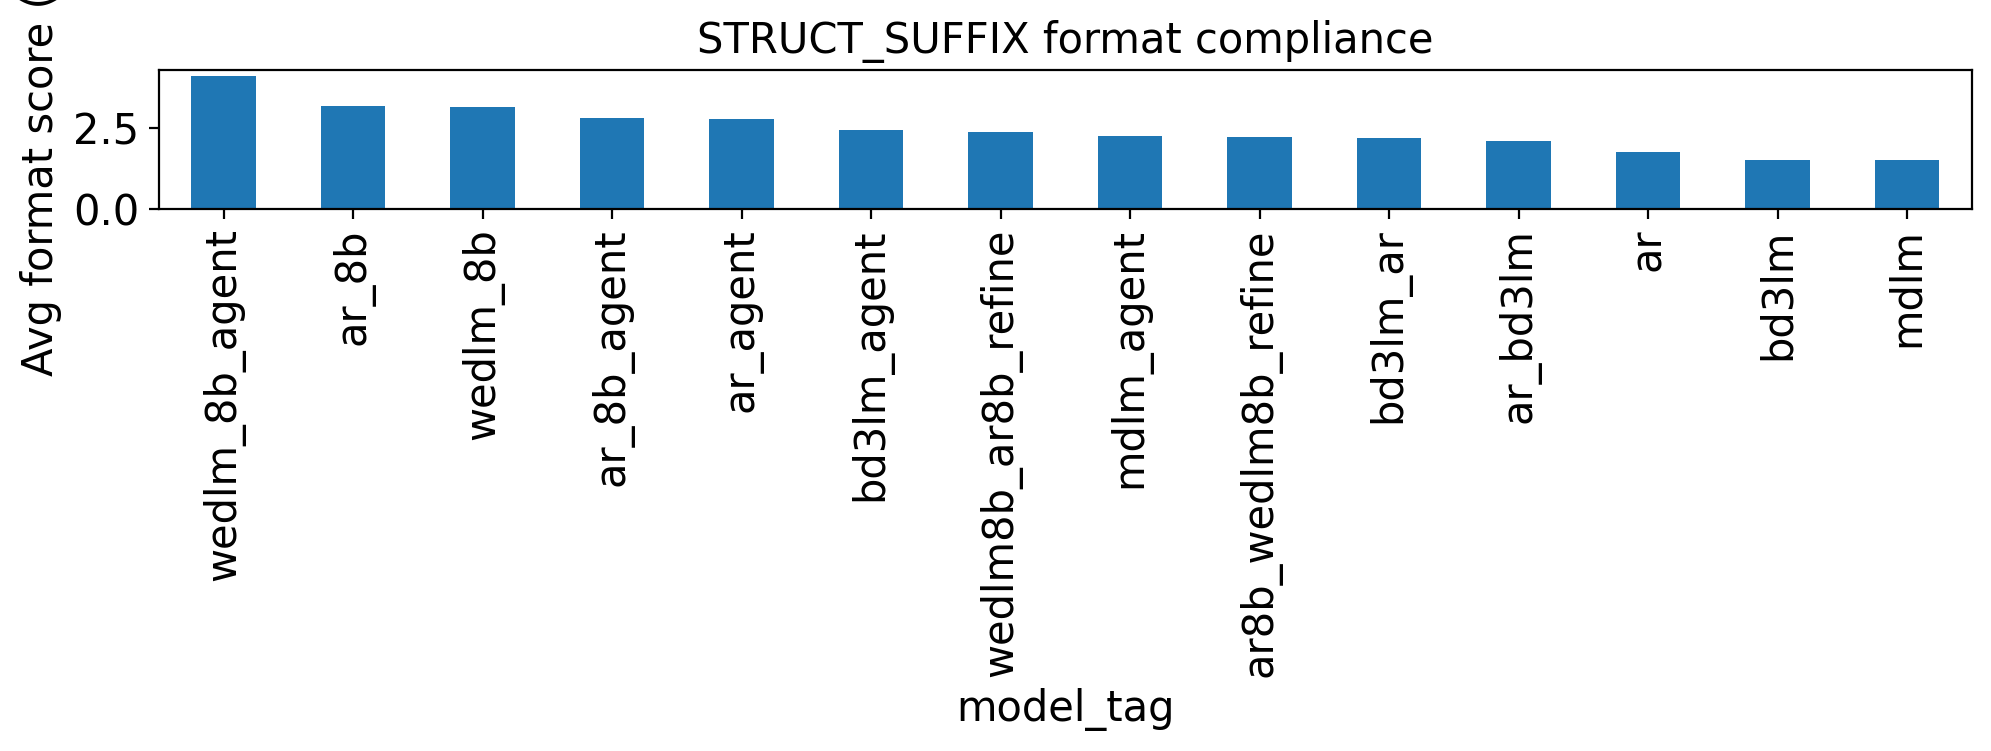

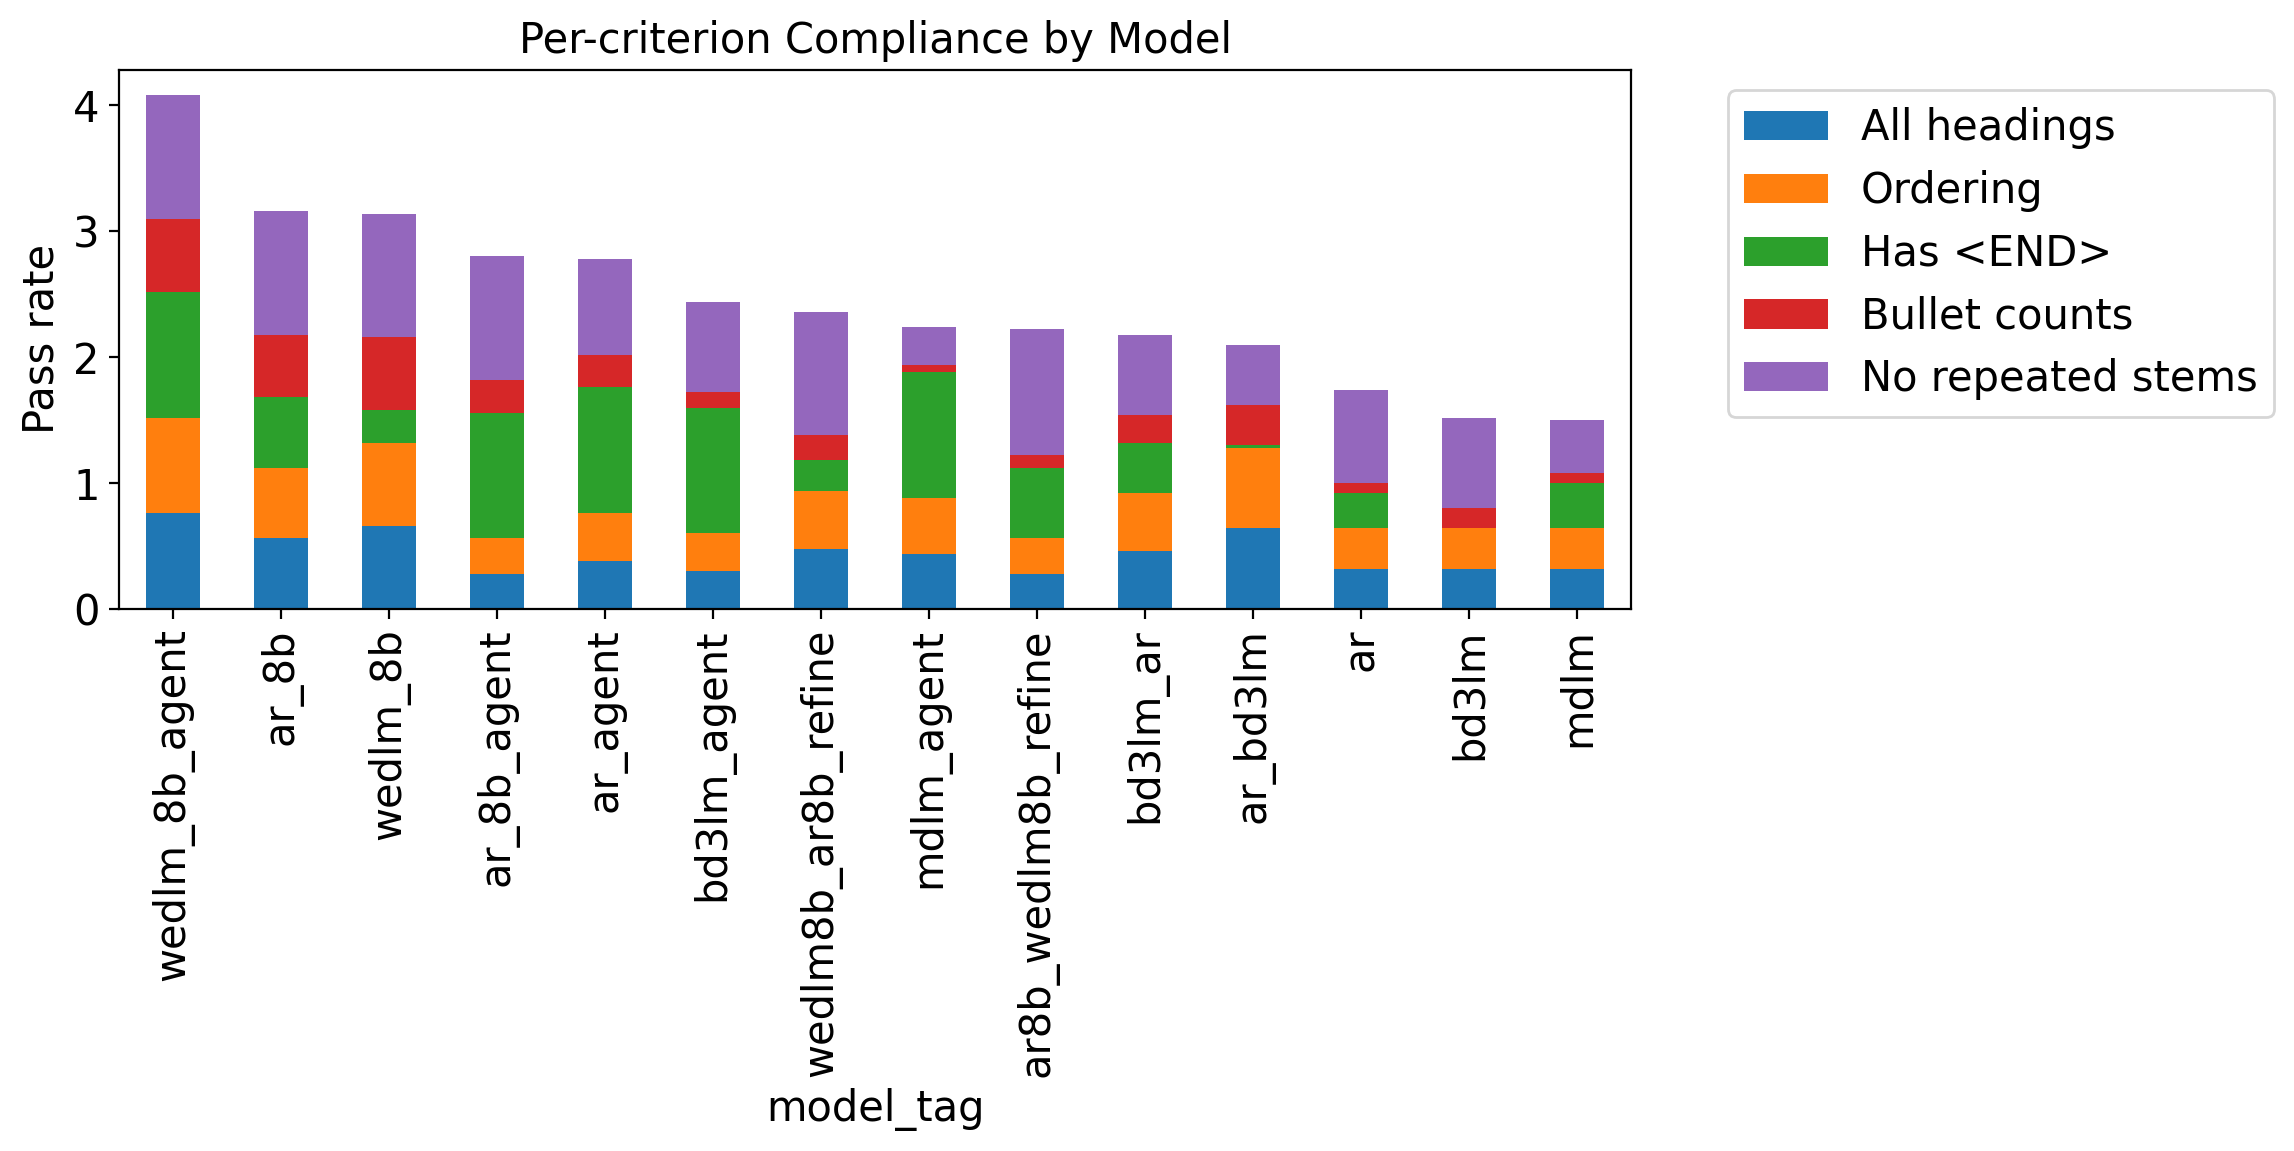

                     fmt_all_headings  fmt_order_ok  fmt_has_end  \
model_tag                                                          
wedlm_8b_agent                   0.76          0.76         1.00   
ar_8b                            0.56          0.56         0.56   
wedlm_8b                         0.66          0.66         0.26   
ar_8b_agent                      0.28          0.28         1.00   
ar_agent                         0.38          0.38         1.00   
bd3lm_agent                      0.30          0.30         1.00   
wedlm8b_ar8b_refine              0.48          0.46         0.24   
mdlm_agent                       0.44          0.44         1.00   
ar8b_wedlm8b_refine              0.28          0.28         0.56   
bd3lm_ar                         0.46          0.46         0.40   
ar_bd3lm                         0.64          0.64         0.02   
ar                               0.32          0.32         0.28   
bd3lm                            0.32          0

In [7]:
fmt_cols = [
    "fmt_all_headings",
    "fmt_order_ok",
    "fmt_has_end",
    "fmt_bullet_counts_ok",
    "fmt_no_repeat_stems",
]

# --- Average overall score by model ---
avg_score = (
    df.groupby("model_tag")["format_score_0_5"]
      .mean()
      .sort_values(ascending=False)
)

ax = avg_score.plot(kind="bar", figsize=(10, 4))
ax.set_ylabel("Avg format score (0–5)")
ax.set_title("STRUCT_SUFFIX format compliance")
plt.tight_layout()
plt.show()

# --- Per-criterion pass rates by model (stacked bar) ---
fmt_pass_rates = df.groupby("model_tag")[fmt_cols].mean()
fmt_pass_rates = fmt_pass_rates.loc[fmt_pass_rates.sum(axis=1).sort_values(ascending=False).index]

ax = fmt_pass_rates.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_ylabel("Pass rate")
ax.set_title("Per-criterion Compliance by Model")
ax.legend(
    ["All headings", "Ordering", "Has <END>", "Bullet counts", "No repeated stems"],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
plt.tight_layout()
plt.savefig("constraint_compliance_by_model.pdf", bbox_inches="tight")
plt.show()

print(fmt_pass_rates.round(3))


**Radar Plot**

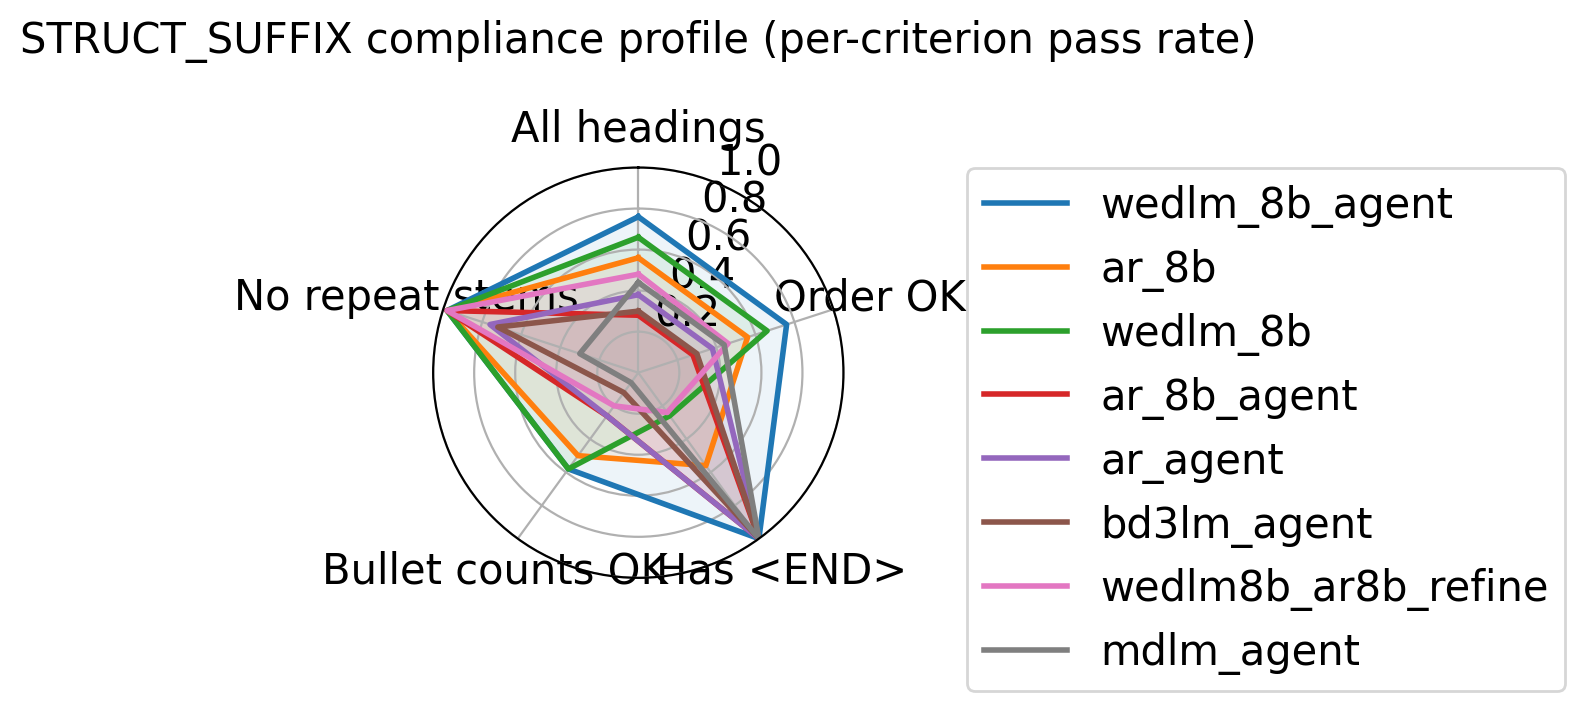

In [8]:
labels = ["All headings", "Order OK", "Has <END>", "Bullet counts OK", "No repeat stems"]

pass_rates = df.groupby("model_tag")[fmt_cols].mean()

top_n = 8
models_to_plot = list(
    df.groupby("model_tag")["format_score_0_5"]
      .mean()
      .sort_values(ascending=False)
      .head(top_n)
      .index
)

def radar_plot(pass_rates_df: pd.DataFrame, labels: list[str], models: list[str], title: str = ""):
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)   # first axis at top
    ax.set_theta_direction(-1)       # clockwise

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])

    for m in models:
        if m not in pass_rates_df.index:
            continue
        vals = pass_rates_df.loc[m].tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=m)
        ax.fill(angles, vals, alpha=0.08)

    ax.set_title(title, pad=20)
    ax.legend(bbox_to_anchor=(1.25, 1.05), loc="upper left")
    plt.tight_layout()
    plt.show()

radar_plot(
    pass_rates,
    labels,
    models_to_plot,
    title="STRUCT_SUFFIX compliance profile (per-criterion pass rate)",
)
